# Classificazione funzionale delle proteine

* Questo progetto si pone l'obiettivo di trovare un modello di machine learning in grado di classificare la funzione di una proteina date informazioni ottenute dall'analisi.
* La sequenza di amminoacidi che compongono la proteina verrà considerata solo in un secondo momento. In questo modo possiamo chiaramente notare l'importanza delle feature estratte dalla composizione della proteina.

Dataset preso da Kaggle: https://www.kaggle.com/datasets/shahir/protein-data-set

Importiamo le prime librerie

In [151]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import precision_score, recall_score

Utilizziamo una lista per mantenere i punteggi ottenuti dai diversi modelli con lo scopo di effettuare un'analisi finale

In [152]:
scores = []

## Dataset senza sequenza

Carichiamo nel DataFrame ```data``` il primo dataset, nel quale non è presenta la sequenza di amminoacidi che descrive la proteina.



In [153]:
data = pd.read_csv("pdb_data_no_dups.csv", index_col="structureId")
data.head(1)

,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
structureId,,,,,,,,,,,,,
100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.9,6360.3,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0


* Eliminiamo dal dataset le feature meno interessanti, come l'anno di pubblicazione della ricerca e il metodo di cristallizzazione.
* Rimuoviamo dal dataset le righe con indice duplicato

In [154]:
data.drop(columns= ["experimentalTechnique", "publicationYear", "pdbxDetails", "crystallizationMethod", "resolution", "phValue"], inplace = True)

data = data[~data.index.isin(data[data.index.duplicated()].index)]

* Analizziamo le feature rimanenti:
  1. ```macromoleculeType``` : tipo di macromolecola a cui la proteina appartiene. Le proteine possono essere classificate in diversi tipi come enzimi, recettori, anticorpi o proteine strutturali.  
  2. ```residueCount```: numero di amminoacidi che compongono la proteina
  3. ```structureMolecularWeight```: peso molecolare della struttura proteica.
  4. ```crystallizationTempK```: temperatura a cui il campione proteico viene cristallizzato durante il processo sperimentale.
  5. ```densityMatthews```: misura della densità di impacchettamento delle molecole all'interno di una rete cristallina.
  6. ```densityPercentSol```: un'altra misura della densità di impacchettamento in una rete cristallina.



* Possiamo notare che questo dataset contiene numerosi valori nulli.
  

In [155]:
data.shape[0] - data.count()

classification                  2
macromoleculeType            3694
residueCount                    0
structureMolecularWeight        0
crystallizationTempK        44231
densityMatthews             16237
densityPercentSol           16212
dtype: int64

* Dato che abbiamo a disposizione molti dati, eliminiamo le righe contenenti valori mancanti.

In [156]:
data.drop(data[data["classification"].isna()].index, inplace=True)
data.drop(data[data["macromoleculeType"].isna()].index, inplace=True)
data.drop(data[data["crystallizationTempK"].isna()].index, inplace=True)
data.drop(data[data["densityMatthews"].isna()].index, inplace=True)
data.drop(data[data["densityPercentSol"].isna()].index, inplace=True)

data.shape[0] - data.count()

classification              0
macromoleculeType           0
residueCount                0
structureMolecularWeight    0
crystallizationTempK        0
densityMatthews             0
densityPercentSol           0
dtype: int64

**Analisi dei dati**
* Visualizziamo in un grafico a barre la distribuzione delle classi nel dataset

<Axes: xlabel='classification'>

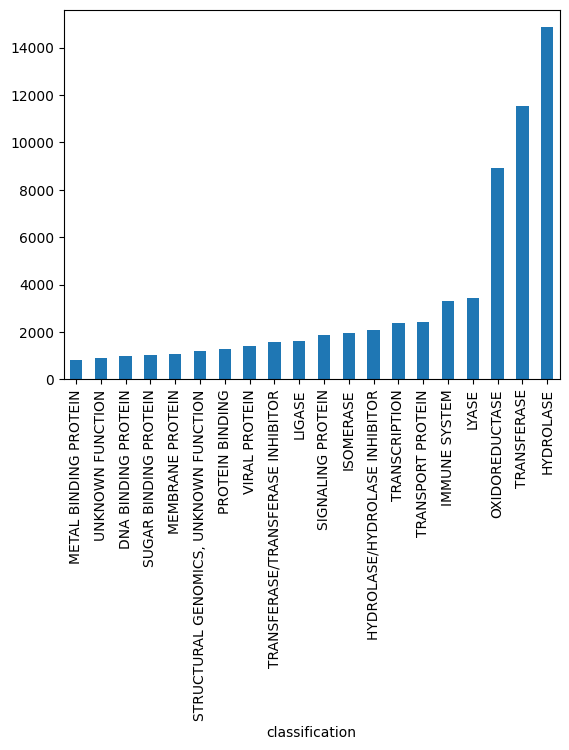

In [157]:
data.groupby("classification").size().sort_values()[-20:].plot.bar()

*   Dato che la distribuzione è molto sbilanciata, decido di mantenere solo le 5 classi più numerose



In [158]:
classes = data.groupby("classification").size().sort_values()[-5:].index
classes

Index(['IMMUNE SYSTEM', 'LYASE', 'OXIDOREDUCTASE', 'TRANSFERASE', 'HYDROLASE'], dtype='object', name='classification')

* Analizziamo la colonna categorica ```macromoleculeType```, che descrive a quale tipo di macromolecola la proteina appartiene.

<Axes: >

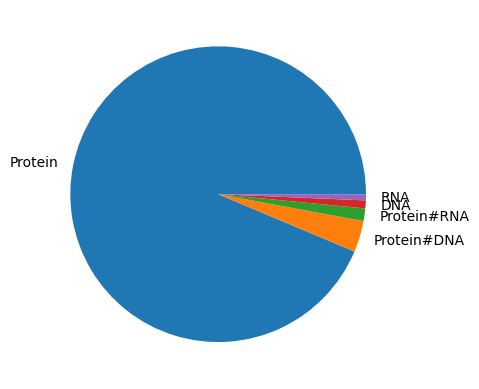

In [159]:
data.groupby("macromoleculeType").size().sort_values(ascending=False)[:5].plot.pie()

* Notiamo che è presente un grande sbilanciamento sul tipo "Protein". Questo potrebbe rendere inefficace l'utilizzo di questa feature.
* Per ora, comunque, la teniamo in considerazione.
* Però manteniamo solo le righe che hanno come valore di questa feature uno dei tre valori più numerosi.

In [160]:
macromolecules = data.groupby("macromoleculeType").size().sort_values()[-3:].index

In [161]:
data = data[data["classification"].isin(classes)]
data = data[data["macromoleculeType"].isin(macromolecules)]
data.shape[0]

42058

Il dataset così ristretto contiene oltre 42.000 entries.

**Preparazione dei dati**

Prepariamo i dati per l'addestramento dei modelli.

In [162]:
X = data.drop(columns=["classification"])
y = data["classification"]

In [163]:
X.head()

,macromoleculeType,residueCount,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol
structureId,,,,,,
1A4S,Protein,2012,217689.59,287.0,2.43,41.00
1A6Q,Protein,382,42707.55,277.0,2.97,59.00
1A72,Protein,374,40658.50,277.0,2.30,46.82
1AFK,Protein,248,28431.01,289.0,2.20,48.00
1AFL,Protein,248,28815.26,289.0,2.20,48.00


In [164]:
y.head()

structureId
1A4S    OXIDOREDUCTASE
1A6Q         HYDROLASE
1A72    OXIDOREDUCTASE
1AFK         HYDROLASE
1AFL         HYDROLASE
Name: classification, dtype: object

Dividiamo i dati in set di allenamento e set di test.

In [165]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

**Modelli**
* importiamo le librerie che ci servono
* definiamo una funzione di appoggio per creare oggetti ```Pipeline``` dato il modello di classificazione che desideriamo usare



In [166]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV



* Il primo modello che testiamo è ```DecisionTreeClassifier```






In [167]:
def buildModel(classifier):
  model =  Pipeline([
      ("preproc", ColumnTransformer([
          ("numeric", StandardScaler(), num_cols),
          ("categorical", OneHotEncoder(), cat_cols)
      ])),

      ("class", classifier)
  ])
  return model

* nel valutare i parametri ottimi utilizziamo una grid search con stratified 3-fold

In [168]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

In [169]:
num_cols = ["residueCount", "structureMolecularWeight", "densityMatthews", "densityPercentSol", "crystallizationTempK"]
cat_cols = ["macromoleculeType"]

model = buildModel(DecisionTreeClassifier())

grid_decision_tree = {
    'class__criterion': ['gini', 'entropy', 'log_loss'],
    "class__splitter":['random','best'],
    'class__max_depth':[8,16,32],
    'class__max_features': ['sqrt', 'log2']
}

gs = GridSearchCV(model, grid_decision_tree, cv=skf, scoring="accuracy")
gs.fit(X_train, y_train)

dt_model = gs.best_estimator_
gs.best_params_

{'class__criterion': 'gini',
 'class__max_depth': 32,
 'class__max_features': 'log2',
 'class__splitter': 'best'}

In [170]:
dt_model.fit(X_train, y_train)
p, r = precision_score(y_val, dt_model.predict(X_val), average='macro'), recall_score(y_val, dt_model.predict(X_val), average='macro')
scores.append(p)
p, r

(0.4942709541302059, 0.4902505043078925)

* infine, testiamo un modello ```XGBClassifier```

In [171]:
def encode_y(y):
  return y.apply(lambda x: classes.tolist().index(x))

In [172]:
from xgboost import XGBClassifier

model = buildModel(XGBClassifier(
    n_estimators=100,
    objective="multi:softmax",
    learning_rate=0.01,
    colsample_bytree=0.2,
    eval_metric="mlogloss",
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gamma=1,
    subsample=0.8,
))

grid_xgb = {
    "class__gamma": [0.5, 1, 1.5],
    "class__subsample": [0.4, 0.6, 0.8],
    "class__max_depth": [15, 20, 25],
}
gs = GridSearchCV(model, grid_xgb, cv=skf, scoring="accuracy")


gs.fit(X_train, encode_y(y_train))

xgb_model = gs.best_estimator_
gs.best_params_

{'class__gamma': 0.5, 'class__max_depth': 20, 'class__subsample': 0.8}

In [173]:
xgb_model.fit(X_train, encode_y(y_train))
p, r = precision_score(encode_y(y_val), xgb_model.predict(X_val), average='macro'), recall_score(encode_y(y_val), xgb_model.predict(X_val), average='macro')
scores.append(p)
p, r

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5061044362798599, 0.23119868094777424)

## Dataset con informazioni sulla sequenza

* Abbiamo visto che i modelli visti, addestrati su un dataset che non tiene conto della sequenza che compone la proteina, non raggiungono buoni risultati.

* Proviamo adesso ad aggiungere al nostro dataset feature estratte dalla sequenza

In [174]:
seq_data = pd.read_csv("pdb_data_seq.csv")[["structureId","sequence"]]
seq_data

,structureId,sequence
0,100D,CCGGCGCCGG
1,100D,CCGGCGCCGG
2,101D,CGCGAATTCGCG
3,101D,CGCGAATTCGCG
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
...,...,...
467299,9XIA,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
467300,9XIM,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467301,9XIM,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467302,9XIM,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...


* Eliminiamo le righe in cui manca la sequenza
* Dato che la sequenza è divisa su più righe, le unisco

In [175]:
seq_data = seq_data[~seq_data["sequence"].isna()]

s = pd.Series(seq_data.groupby("structureId")["sequence"], index=seq_data["structureId"].unique())
s = s.apply(lambda x: "".join(x[1].tolist()))
seq_df = pd.DataFrame(s, columns=["sequence"])
seq_df.head()

,sequence
100D,CCGGCGCCGGCCGGCGCCGG
101D,CGCGAATTCGCGCGCGAATTCGCG
101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102D,CGCAAATTTGCGCGCAAATTTGCG
102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...


* Faccio corrispondere le righe del dataset delle sequenze con le righe del dataset originale

In [176]:
data_seq = pd.DataFrame(data)
seq_df = seq_df[seq_df.index.isin(data_seq.index)]
data_seq = data_seq[data_seq.index.isin(seq_df.index)]

In [177]:
(seq_df.index == data_seq.index).all()

True

* Inserisco le sequenze nel database con le altre features

In [178]:
data_seq["sequence"] = seq_df["sequence"]
data_seq.head(1)

,classification,macromoleculeType,residueCount,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,sequence
structureId,,,,,,,,
1A4S,OXIDOREDUCTASE,Protein,2012,217689.59,287.0,2.43,41.0,AQLVDSMPSASTGSVVVTDDLNYWGGRRIKSKDGATTEPVFEPATG...


**Estrazione di nuove features**
* Dalla sequenza di amminoacidi è possibile estrarre diverse informazioni utili
* Per esempio, la frequenza di ciascun amminoacido nella sequenza

In [179]:
amms = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X','Y']

for amm in amms:
  data_seq.loc[:, f"freq_{amm}"] = data_seq.loc[:, "sequence"].apply(lambda x: x.count(amm) / len(x))

* Altre caratteristiche possono essere estratte attraverso la libreria ```biopython```

In [180]:
#pip install biopython

In [181]:
from Bio.Seq import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [182]:
aromaticity = pd.Series([ProteinAnalysis(Seq(s)).aromaticity() for s in data_seq["sequence"]], index=data_seq.index)
isoelectric = pd.Series([ProteinAnalysis(Seq(s)).isoelectric_point() for s in data_seq["sequence"]], index=data_seq.index)
secondary = pd.DataFrame([ProteinAnalysis(Seq(s)).secondary_structure_fraction() for s in data_seq["sequence"]], index=data_seq.index, columns = ["helix", "turn","sheet"])

In [183]:
data_seq["aromaticity"] = aromaticity
data_seq["isoelectricPoint"] = isoelectric
for feature in ["helix", "turn","sheet"]:
  data_seq.loc[:,feature] = secondary.loc[:,feature]

In [184]:
data_seq.head(1)

,classification,macromoleculeType,residueCount,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,sequence,freq_A,freq_C,...,freq_T,freq_V,freq_W,freq_X,freq_Y,aromaticity,isoelectricPoint,helix,turn,sheet
structureId,,,,,,,,,,,,,,,,,,,,,
1A4S,OXIDOREDUCTASE,Protein,2012,217689.59,287.0,2.43,41.0,AQLVDSMPSASTGSVVVTDDLNYWGGRRIKSKDGATTEPVFEPATG...,0.093439,0.027833,...,0.063618,0.101392,0.00994,0.0,0.025845,0.073559,5.856258,0.298211,0.232604,0.270378


**Preparazione dei dati**
* Otteniamo dal dataset etichette e features.
* Dividiamo i dati in train set e validation set

In [185]:
X_seq = data_seq.drop(columns=["classification", "sequence"])
y_seq = data_seq["classification"]

In [186]:
X_seq_train, X_seq_val, y_seq_train, y_seq_val = train_test_split(
    X_seq, y_seq,
    test_size=1/3,
    random_state=42
)

* Aggiorniamo la lista delle colonne numeriche

In [187]:
num_cols=["residueCount", "structureMolecularWeight", "crystallizationTempK", "densityMatthews", "densityPercentSol", *[f"freq_{a}" for a in amms], "aromaticity", "isoelectricPoint", "helix", "turn", "sheet"]

* Testiamo gli stessi modelli già considerati

* ```DecisionTreeClassifier```



In [188]:
model = buildModel(DecisionTreeClassifier())

grid_decision_tree = {
    'class__criterion': ['gini', 'entropy', 'log_loss'],
    "class__splitter":['random','best'],
    'class__max_depth':[8,16,32],
    'class__max_features': ['sqrt', 'log2']
}

gs = GridSearchCV(model, grid_decision_tree, cv=skf, scoring="accuracy")
gs.fit(X_seq_train, y_seq_train)

dt_seq_model = gs.best_estimator_
gs.best_params_

{'class__criterion': 'log_loss',
 'class__max_depth': 32,
 'class__max_features': 'sqrt',
 'class__splitter': 'best'}

In [189]:
dt_seq_model.fit(X_seq_train, y_seq_train)
p, r = precision_score(y_seq_val, dt_seq_model.predict(X_seq_val), average='macro'), recall_score(y_seq_val, dt_seq_model.predict(X_seq_val), average='macro')
scores.append(p)
p, r

(0.7830163289415779, 0.7798787271620602)

* ```XGBClassifier```

In [190]:
model = buildModel(XGBClassifier(
    n_estimators=100,
    objective="multi:softmax",
    learning_rate=0.01,
    colsample_bytree=0.2,
    eval_metric="mlogloss",
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gamma=1,
    subsample=0.8,
    max_depth = 20
))

grid_xgb = {
    "class__gamma": [0.5, 1, 1.5],
    "class__subsample": [0.4, 0.6, 0.8],
}
gs = GridSearchCV(model, grid_xgb, cv=skf, scoring="accuracy")


gs.fit(X_seq_train, encode_y(y_seq_train))

xgb_seq_model = gs.best_estimator_
gs.best_params_

{'class__gamma': 0.5, 'class__subsample': 0.8}

In [191]:
xgb_seq_model.fit(X_seq_train, encode_y(y_seq_train))
p, r = precision_score(encode_y(y_seq_val), xgb_seq_model.predict(X_seq_val), average='macro'), recall_score(encode_y(y_seq_val), xgb_seq_model.predict(X_seq_val), average='macro')
scores.append(p)
p, r

(0.8975074703874769, 0.792901891046354)

## Analisi dei risultati

* Confrontiamo in un grafico i risultati ottenuti con i due diversi dataset

<BarContainer object of 4 artists>

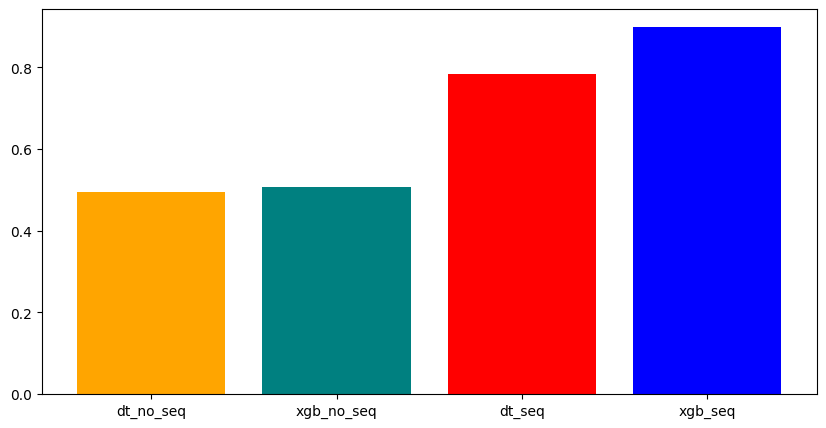

In [192]:
c = ["orange", "teal", "red", "blue"]
plt.figure(figsize=(10,5))
plt.bar([f"{m}_{i}" for i in ["no_seq","seq"] for m in ["dt", "xgb"] ],scores, color=c)

* Analizziamo l'importanza di ciascuna feature, considerando il dataset contenente la sequenza e il modello che ha ottenuto il punteggio migliore.

In [193]:
xgb_seq_model.named_steps["class"].feature_importances_

array([0.02872855, 0.02762738, 0.01843041, 0.01874978, 0.0186138 ,
       0.02959302, 0.03565611, 0.02781372, 0.03330971, 0.02693922,
       0.03028884, 0.02531593, 0.02924377, 0.02834032, 0.03120296,
       0.02765499, 0.03244499, 0.02958786, 0.02711901, 0.0285547 ,
       0.0388724 , 0.03028297, 0.02671082, 0.03190553, 0.03383037,
       0.02994771, 0.02833843, 0.02760422, 0.03223315, 0.03810939,
       0.0369745 , 0.02521384, 0.03131993, 0.03344166], dtype=float32)

In [194]:
from sklearn.inspection import permutation_importance

results = permutation_importance(dt_seq_model, X_seq_train, y_seq_train, n_repeats=10, random_state=42)
importances = results.importances_mean
pd.Series(importances, index=X_seq.columns).sort_values(ascending=False)

sheet                       0.337795
freq_A                      0.309116
turn                        0.205753
helix                       0.188758
isoelectricPoint            0.164102
freq_C                      0.154629
freq_P                      0.141265
freq_T                      0.135587
freq_I                      0.128019
freq_W                      0.125209
aromaticity                 0.110357
freq_D                      0.110261
freq_R                      0.110243
freq_G                      0.107650
residueCount                0.106402
freq_N                      0.101694
freq_Q                      0.098195
freq_Y                      0.082552
freq_F                      0.082049
freq_E                      0.080708
freq_S                      0.079991
freq_L                      0.077331
freq_V                      0.067212
freq_H                      0.062376
freq_K                      0.054925
freq_M                      0.052090
structureMolecularWeight    0.038772
d

* Possiamo notare che le feature che vengono considerate meno sono due:
  1. ```macromoleculeType```: avevamo già notato che la grande sproporzione dei dati avrebbe potuto rendere inefficace l'utilizzo di questa informazione
  2. ```freq_X```: infatti X non è un vero amminoacido, serve solo a segnalare che non è sicuro quale amminoacido si trovi in quella posizione nella sequenza.

* Le feature ottenute dalla sequenza sono risultate molto utili alla classificazione, soprattutto ```sheet```, ```turn``` e ```helix```. Infatti la struttura secondaria (definita appunto da queste caratteristiche) è fondamentale nel determinare la funzione delle proteine.


## Conclusioni

Tramite un semplice modello di classificazione Decision Tree, siamo stati in grado di classificare con una buona precisione le proteine all'interno di 5 categorie funzionali:
* IMMUNE SYSTEM
* LYASE
* OXIDOREDUCTASE
* TRANSFERASE
* HYDROLASE

In particolare abbiamo potuto cogliere l'intima correlazione esistente tra la sequenza di amminoacidi e la funzione di una proteina. Infatti, i modelli visti sono stati in grado di selezionare come più importanti le feature relative alla sequenza e alla struttura secondaria delle proteine rispetto a caratteristiche più generiche.

